# What's My Flight Status?
***
Author: Andre Layton
***



# Overview
Notes: Construct like an abstract - summary of my entire analysis: 
mention dataset sources, my workflow steps and process, results, evaluations, and conclusions drawn!

# Business Problem

The *Wall Street Journal* recently released their annual airline rankings report, where United Airlines dropped out of the top five. Now at \#6, due to a variety of issues including plane troubles (i.e., the Boeing 737s over the last 8 years), the company’s executive team decided to tackle the issues with growing delays to regain consumer confidence. I’ve been hired to create an algorithm that can predict flight delays, which will be deployed as an app for consumers to be able to track their flights. This is important for both the airline and potential passengers – for the airline, it will help with flight logistics and reduce fees due to delays (i.e. tarmac fees, reimbursements, etc.). For passengers, the app will allow them to make delay arrangements and take measures ahead of time, and possibly save on delay expenses. While delays are frustrating whether expected or not, United aims to use this strategy to display company honesty and gain more control over their flights.

<img src="https://res.cloudinary.com/sagacity/image/upload/c_crop,h_2799,w_4199,x_0,y_0/c_limit,dpr_auto,f_auto,fl_lossy,q_80,w_1080/shutterstock_402702424_dlgrgk.jpg" style="height:650px" />

# Data Understanding 


In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import math
from IPython.display import HTML
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, classification_report,\
                            roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import svm
from sklearn.inspection import permutation_importance
import joblib

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers, optimizers
from keras.applications import ResNet50
import os, shutil, random

# Create a seed for reproducibility
seed=24

In [2]:
# Load the metadata (column descriptions)
metadata = open("data/raw_data_documentation.txt", "r")
print(metadata.read())

AIRPORT_COORDINATES
	ORIGIN_AIRPORT_ID: 	Airport ID, matches to ORIGIN_AIRPORT_ID in other files
	DISPLAY_AIRPORT_NAME:  	Display Airport, matches to DISPLAY_AIRPORT_NAME in other files
	LATITUDE: 		Latitude for airport
	LONGITUDE: 		Longitude for airport

B43_AIRCRAFT_INVENTORY
	MANUFACTURE_YEAR: 	Manufacture year
	TAIL_NUM: 		Unique tail number, matches to TAIL_NUM in other files
	NUMBER_OF_SEATS: 	Number of seats on aircraft
	
CARRIER_DECODE
	AIRLINE_ID: 		Airport ID, matches to AIRLINE_ID in other files
	OP_UNIQUE_CARRIER: 	Carrier code, matches to OP_UNIQUE_CARRIER in other files
	CARRIER_NAME: 		Carrier name, matches to UNIQUE_CARRIER_NAME or CARRIER_NAME in other files

ONTIME_REPORTING_XX
	MONTH: 			Month
	DAY_OF_MONTH: 		Day of the month (1-31)
	DAY_OF_WEEK: 		Day of the week
	OP_UNIQUE_CARRIER: 	Carrier code, matches to OP_UNIQUE_CARRIER in other files
	TAIL_NUM: 		Unique tail number, matches to TAIL_NUM in other files
	OP_CARRIER_FL_NUM: 	Flight number
	ORIGIN_AIRPORT_ID: 	A

In [3]:
# Load the flight data
data = pd.read_csv('data/full_data_flightdelay.csv')

# Preview the first 10 records
data.head(10)

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,1,7,0,0800-0859,2,1,25,143,Southwest Airlines Co.,13056,...,8,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
1,1,7,0,0700-0759,7,1,29,191,Delta Air Lines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
2,1,7,0,0600-0659,7,1,27,199,Delta Air Lines Inc.,13056,...,18,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
3,1,7,0,0600-0659,9,1,27,180,Delta Air Lines Inc.,13056,...,2,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
4,1,7,0,0001-0559,7,1,10,182,Spirit Air Lines,13056,...,1,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
5,1,7,0,0001-0559,3,1,10,180,Frontier Airlines Inc.,13056,...,5,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
6,1,7,0,0700-0759,6,1,29,186,Frontier Airlines Inc.,13056,...,2,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
7,1,7,1,0001-0559,7,1,10,186,Frontier Airlines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
8,1,7,0,0001-0559,7,1,10,180,Frontier Airlines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
9,1,7,0,0600-0659,8,1,27,186,Frontier Airlines Inc.,13056,...,1,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91


In [4]:
# Print column information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6489062 entries, 0 to 6489061
Data columns (total 26 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   MONTH                          int64  
 1   DAY_OF_WEEK                    int64  
 2   DEP_DEL15                      int64  
 3   DEP_TIME_BLK                   object 
 4   DISTANCE_GROUP                 int64  
 5   SEGMENT_NUMBER                 int64  
 6   CONCURRENT_FLIGHTS             int64  
 7   NUMBER_OF_SEATS                int64  
 8   CARRIER_NAME                   object 
 9   AIRPORT_FLIGHTS_MONTH          int64  
 10  AIRLINE_FLIGHTS_MONTH          int64  
 11  AIRLINE_AIRPORT_FLIGHTS_MONTH  int64  
 12  AVG_MONTHLY_PASS_AIRPORT       int64  
 13  AVG_MONTHLY_PASS_AIRLINE       int64  
 14  FLT_ATTENDANTS_PER_PASS        float64
 15  GROUND_SERV_PER_PASS           float64
 16  PLANE_AGE                      int64  
 17  DEPARTING_AIRPORT              object 
 18  LA

In [5]:
# Print airline information
data['CARRIER_NAME'].value_counts()

Southwest Airlines Co.          1296329
Delta Air Lines Inc.             938346
American Airlines Inc.           903640
United Air Lines Inc.            601044
SkyWest Airlines Inc.            584204
Midwest Airline, Inc.            300154
JetBlue Airways                  269596
Alaska Airlines Inc.             239337
American Eagle Airlines Inc.     228792
Comair Inc.                      219324
Endeavor Air Inc.                203827
Spirit Air Lines                 189419
Mesa Airlines Inc.               177600
Frontier Airlines Inc.           120872
Atlantic Southeast Airlines       99044
Hawaiian Airlines Inc.            74898
Allegiant Air                     42636
Name: CARRIER_NAME, dtype: int64

In [6]:
# Find the amount of missing values in each column
data.isna().sum()

MONTH                            0
DAY_OF_WEEK                      0
DEP_DEL15                        0
DEP_TIME_BLK                     0
DISTANCE_GROUP                   0
SEGMENT_NUMBER                   0
CONCURRENT_FLIGHTS               0
NUMBER_OF_SEATS                  0
CARRIER_NAME                     0
AIRPORT_FLIGHTS_MONTH            0
AIRLINE_FLIGHTS_MONTH            0
AIRLINE_AIRPORT_FLIGHTS_MONTH    0
AVG_MONTHLY_PASS_AIRPORT         0
AVG_MONTHLY_PASS_AIRLINE         0
FLT_ATTENDANTS_PER_PASS          0
GROUND_SERV_PER_PASS             0
PLANE_AGE                        0
DEPARTING_AIRPORT                0
LATITUDE                         0
LONGITUDE                        0
PREVIOUS_AIRPORT                 0
PRCP                             0
SNOW                             0
SNWD                             0
TMAX                             0
AWND                             0
dtype: int64

In [7]:
# Make a copy of the dataset
data2 = data.copy()

In [8]:
# Filter United Airlines's records and list the first 10
data2 = data2.loc[data2['CARRIER_NAME'] == 'United Air Lines Inc.']
data2.head(10)

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
21,1,7,0,0800-0859,2,1,25,173,United Air Lines Inc.,13056,...,6,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
22,1,7,0,0800-0859,3,1,25,142,United Air Lines Inc.,13056,...,22,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
23,1,7,0,0900-0959,7,1,28,154,United Air Lines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
24,1,7,1,1000-1059,3,1,29,142,United Air Lines Inc.,13056,...,19,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
25,1,7,0,0600-0659,7,1,27,173,United Air Lines Inc.,13056,...,4,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
26,1,7,0,0700-0759,1,1,29,154,United Air Lines Inc.,13056,...,21,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
27,1,7,0,0600-0659,2,1,27,154,United Air Lines Inc.,13056,...,20,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
28,1,7,0,0600-0659,9,1,27,173,United Air Lines Inc.,13056,...,11,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
29,1,7,0,0001-0559,5,1,10,154,United Air Lines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
30,1,7,0,0600-0659,3,1,27,173,United Air Lines Inc.,13056,...,4,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91


In [9]:
# Drop unnecessary columns and display column information 
cols_to_drop = ['SEGMENT_NUMBER', 'NUMBER_OF_SEATS', 'FLT_ATTENDANTS_PER_PASS', 'AVG_MONTHLY_PASS_AIRPORT', 
                'GROUND_SERV_PER_PASS', 'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'PREVIOUS_AIRPORT', 'AVG_MONTHLY_PASS_AIRLINE',
                'LATITUDE', 'LONGITUDE', 'CARRIER_NAME', 'CONCURRENT_FLIGHTS', 'AIRPORT_FLIGHTS_MONTH']
data2 = data2.drop(cols_to_drop, axis=1)
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601044 entries, 21 to 6489030
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   MONTH                  601044 non-null  int64  
 1   DAY_OF_WEEK            601044 non-null  int64  
 2   DEP_DEL15              601044 non-null  int64  
 3   DEP_TIME_BLK           601044 non-null  object 
 4   DISTANCE_GROUP         601044 non-null  int64  
 5   AIRLINE_FLIGHTS_MONTH  601044 non-null  int64  
 6   PLANE_AGE              601044 non-null  int64  
 7   DEPARTING_AIRPORT      601044 non-null  object 
 8   PRCP                   601044 non-null  float64
 9   SNOW                   601044 non-null  float64
 10  SNWD                   601044 non-null  float64
 11  TMAX                   601044 non-null  float64
 12  AWND                   601044 non-null  float64
dtypes: float64(5), int64(6), object(2)
memory usage: 64.2+ MB


In [10]:
# Rename the columns for easier comprehension & list the first 5 records
new_col_names = {'DEP_DEL15': 'DELAYED',
                'PRCP': 'PRECIPITATION',
                'SNWD': 'SNOW_ON_GROUND',
                'TMAX': 'MAX_TEMP_FOR_DAY',
                'AWND': 'MAX_WIND_FOR_DAY'}
data2 = data2.rename(new_col_names, axis=1)
data2.head()

,MONTH,DAY_OF_WEEK,DELAYED,DEP_TIME_BLK,DISTANCE_GROUP,AIRLINE_FLIGHTS_MONTH,PLANE_AGE,DEPARTING_AIRPORT,PRECIPITATION,SNOW,SNOW_ON_GROUND,MAX_TEMP_FOR_DAY,MAX_WIND_FOR_DAY
21,1,7,0,0800-0859,2,46218,6,McCarran International,0.0,0.0,0.0,65.0,2.91
22,1,7,0,0800-0859,3,46218,22,McCarran International,0.0,0.0,0.0,65.0,2.91
23,1,7,0,0900-0959,7,46218,3,McCarran International,0.0,0.0,0.0,65.0,2.91
24,1,7,1,1000-1059,3,46218,19,McCarran International,0.0,0.0,0.0,65.0,2.91
25,1,7,0,0600-0659,7,46218,4,McCarran International,0.0,0.0,0.0,65.0,2.91


In [11]:
# Shift the target column to the end 
cols_at_end = ['DELAYED']
data2 = data2[[col for col in data2 if col not in cols_at_end] 
        + [col for col in cols_at_end if col in data2]]

# Preview the first 5 records to confirm the change
data2.head()

,MONTH,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,AIRLINE_FLIGHTS_MONTH,PLANE_AGE,DEPARTING_AIRPORT,PRECIPITATION,SNOW,SNOW_ON_GROUND,MAX_TEMP_FOR_DAY,MAX_WIND_FOR_DAY,DELAYED
21,1,7,0800-0859,2,46218,6,McCarran International,0.0,0.0,0.0,65.0,2.91,0
22,1,7,0800-0859,3,46218,22,McCarran International,0.0,0.0,0.0,65.0,2.91,0
23,1,7,0900-0959,7,46218,3,McCarran International,0.0,0.0,0.0,65.0,2.91,0
24,1,7,1000-1059,3,46218,19,McCarran International,0.0,0.0,0.0,65.0,2.91,1
25,1,7,0600-0659,7,46218,4,McCarran International,0.0,0.0,0.0,65.0,2.91,0


In [12]:
# Break down the records by month
data2['MONTH'].value_counts().sort_index()

1     44465
2     41598
3     51418
4     50542
5     52644
6     52073
7     53670
8     54066
9     49360
10    53196
11    48450
12    49562
Name: MONTH, dtype: int64

In [13]:
# Break down the records by days of the week
data2['DAY_OF_WEEK'].value_counts().sort_index()

1    89114
2    87840
3    87126
4    87658
5    88782
6    75295
7    85229
Name: DAY_OF_WEEK, dtype: int64

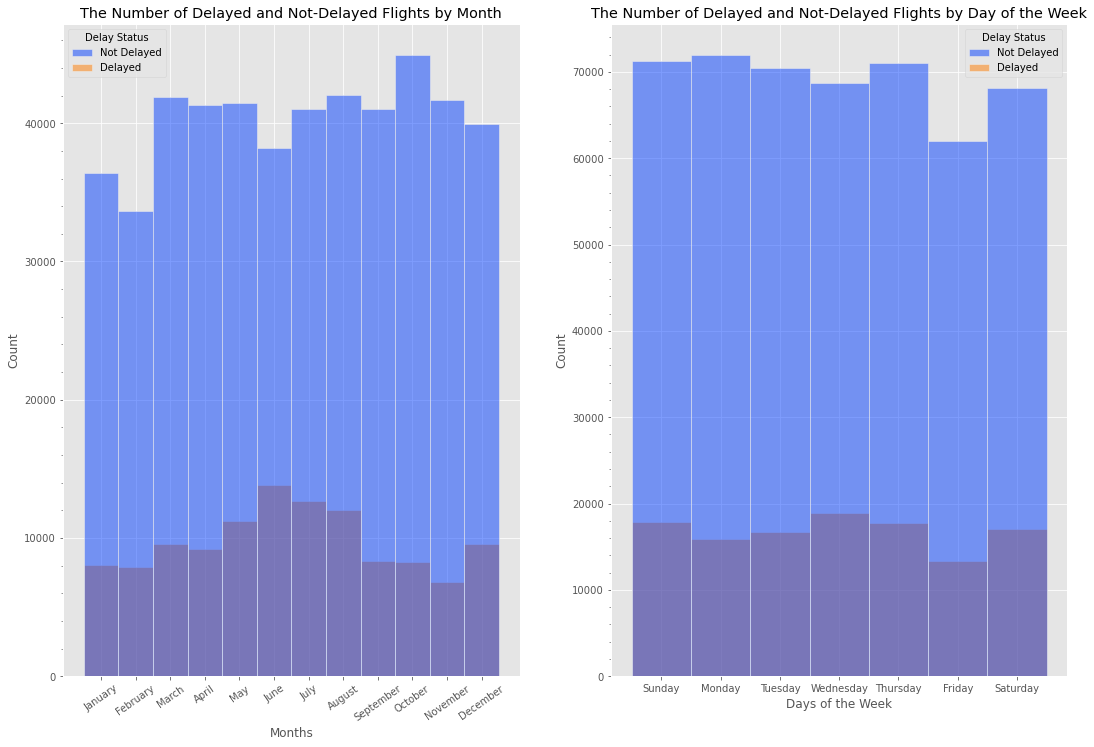

In [14]:
# Plot feature distributions

# Create month and days list objects
months = ['January', 'February', 'March', 'April', 'May', 'June',
         'July', 'August', 'September', 'October', 'November', 'December']
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Visualize the delay status by month
fig, ax = plt.subplots(1, 2, figsize=(18, 12))
plot1 = sns.histplot(data2, x='MONTH', hue='DELAYED', ax=ax[0], palette='bright', discrete=True)

# Change the legend labels
new_title = 'Delay Status'
plot1.legend_.set_title(new_title)
new_labels = ['Not Delayed', 'Delayed']
for t, l in zip(plot1.legend_.texts, new_labels):
    t.set_text(l)
    
# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax[0].yaxis.set_minor_locator(minor_locator)
ax[0].set_axisbelow(True)
plt.grid(which='both')
ax[0].tick_params(which="both", bottom=True)

# Change x-tick labels to months (written form) and rotate the labels
old_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ax[0].set_xticks(old_labels)
ax[0].set_xticklabels(months)
ax[0].tick_params(axis='x', labelrotation=35)
ax[0].set_xlabel("Months")
ax[0].set_title("The Number of Delayed and Not-Delayed Flights by Month")
    
# Visualize the delay status by days of the week    
plot2 = sns.histplot(data2, x='DAY_OF_WEEK', hue='DELAYED', ax=ax[1], palette='bright', discrete=True)

# Change the legend labels
new_title = 'Delay Status'
plot2.legend_.set_title(new_title)
new_labels = ['Not Delayed', 'Delayed']
for t, l in zip(plot2.legend_.texts, new_labels):
    t.set_text(l)

# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax[1].yaxis.set_minor_locator(minor_locator)
ax[1].set_axisbelow(True)
plt.grid(which='both')

# Change x-tick labels to days (written form)
old_labels = [1, 2, 3, 4, 5, 6, 7]
ax[1].set_xticks(old_labels)
ax[1].set_xticklabels(days)
ax[1].set_xlabel("Days of the Week")
ax[1].set_title("The Number of Delayed and Not-Delayed Flights by Day of the Week");

In [15]:
# Break down the records by departure time blocks
data2['DEP_TIME_BLK'].value_counts().sort_index()

0001-0559    10267
0600-0659    42704
0700-0759    48374
0800-0859    44230
0900-0959    38512
1000-1059    36435
1100-1159    35991
1200-1259    35918
1300-1359    29069
1400-1459    34400
1500-1559    30829
1600-1659    35741
1700-1759    37217
1800-1859    37925
1900-1959    35563
2000-2059    22733
2100-2159    20523
2200-2259    13236
2300-2359    11377
Name: DEP_TIME_BLK, dtype: int64

In [16]:
# Break down the records by distance group
data2['DISTANCE_GROUP'].value_counts().sort_index()

1      30152
2      68733
3      83959
4     118255
5      67136
6      47831
7      62163
8      24036
9      16434
10     51936
11     30409
Name: DISTANCE_GROUP, dtype: int64

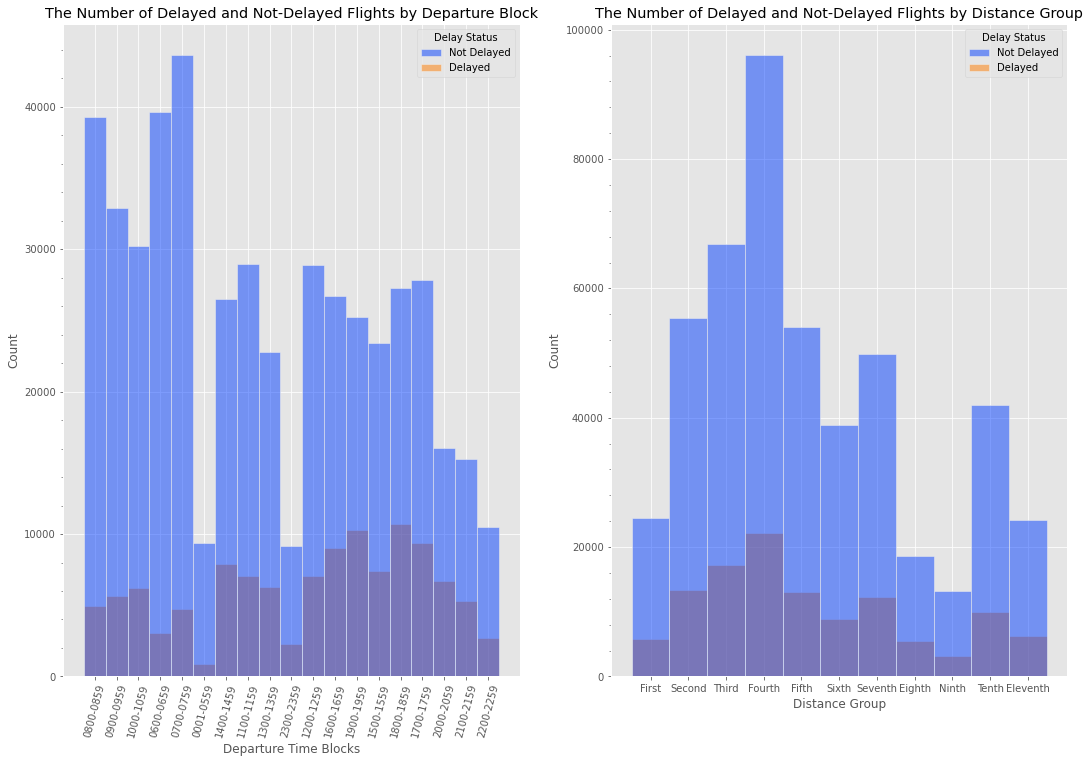

In [17]:
# Plot feature distributions
fig, ax = plt.subplots(1, 2, figsize=(18, 12))

# Visualize the delay status by departure time block
plot3 = sns.histplot(data2, x='DEP_TIME_BLK', hue='DELAYED', ax=ax[0], palette='bright', discrete=True)

# Change legend labels
new_title = 'Delay Status'
plot3.legend_.set_title(new_title)
new_labels = ['Not Delayed', 'Delayed']
for t, l in zip(plot3.legend_.texts, new_labels):
    t.set_text(l)

# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax[0].yaxis.set_minor_locator(minor_locator)
ax[0].set_axisbelow(True)
plt.grid(which='both')

# Rotate x-tick labels
ax[0].tick_params(axis='x', labelrotation=75)
ax[0].tick_params(which="both", bottom=True)
ax[0].set_xlabel("Departure Time Blocks")
ax[0].set_title("The Number of Delayed and Not-Delayed Flights by Departure Block")
    
# Visualize the delay status by distance group  
plot4 = sns.histplot(data2, x='DISTANCE_GROUP', hue='DELAYED', ax=ax[1], palette='bright', discrete=True)

# Change legend labels
new_title = 'Delay Status'
plot4.legend_.set_title(new_title)
new_labels = ['Not Delayed', 'Delayed']
for t, l in zip(plot4.legend_.texts, new_labels):
    t.set_text(l)
    
# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax[1].yaxis.set_minor_locator(minor_locator)
ax[1].set_axisbelow(True)
plt.grid(which='both')

# Change x-tick labels to distance group (written form)
num_xlabels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
str_xlabels = ['First', 'Second', 'Third', 'Fourth', 'Fifth', 'Sixth', 'Seventh', 'Eighth', 'Ninth', 'Tenth', 'Eleventh']
ax[1].set_xticks(num_xlabels)
ax[1].set_xticklabels(str_xlabels)
ax[1].set_xlabel("Distance Group")
ax[1].set_title("The Number of Delayed and Not-Delayed Flights by Distance Group");

In [18]:
# List (and sort) the value counts of each departure time block
value_counts = data2['DEP_TIME_BLK'].value_counts().sort_index()

# Create a dictionary that represents each unique time block with a number
block_number = {value: i for i, value in enumerate(value_counts.index)}

# Replace each time block with its corresponding unique value
data2["DEP_TIME_BLK"] = data2["DEP_TIME_BLK"].map(block_number)
data2.head()

,MONTH,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,AIRLINE_FLIGHTS_MONTH,PLANE_AGE,DEPARTING_AIRPORT,PRECIPITATION,SNOW,SNOW_ON_GROUND,MAX_TEMP_FOR_DAY,MAX_WIND_FOR_DAY,DELAYED
21,1,7,3,2,46218,6,McCarran International,0.0,0.0,0.0,65.0,2.91,0
22,1,7,3,3,46218,22,McCarran International,0.0,0.0,0.0,65.0,2.91,0
23,1,7,4,7,46218,3,McCarran International,0.0,0.0,0.0,65.0,2.91,0
24,1,7,5,3,46218,19,McCarran International,0.0,0.0,0.0,65.0,2.91,1
25,1,7,1,7,46218,4,McCarran International,0.0,0.0,0.0,65.0,2.91,0


In [19]:
# List (and sort) the value counts of each departing airport
value_counts_airports = data2['DEPARTING_AIRPORT'].value_counts().sort_index()

# Create a dictionary that associates each unique airport with a unique number
airport_number = {value: i for i, value in enumerate(value_counts_airports.index)}

# Replace each departing airport with its corresponding unique value
data2['DEPARTING_AIRPORT'] = data2['DEPARTING_AIRPORT'].map(airport_number)
data2.head()

,MONTH,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,AIRLINE_FLIGHTS_MONTH,PLANE_AGE,DEPARTING_AIRPORT,PRECIPITATION,SNOW,SNOW_ON_GROUND,MAX_TEMP_FOR_DAY,MAX_WIND_FOR_DAY,DELAYED
21,1,7,3,2,46218,6,38,0.0,0.0,0.0,65.0,2.91,0
22,1,7,3,3,46218,22,38,0.0,0.0,0.0,65.0,2.91,0
23,1,7,4,7,46218,3,38,0.0,0.0,0.0,65.0,2.91,0
24,1,7,5,3,46218,19,38,0.0,0.0,0.0,65.0,2.91,1
25,1,7,1,7,46218,4,38,0.0,0.0,0.0,65.0,2.91,0


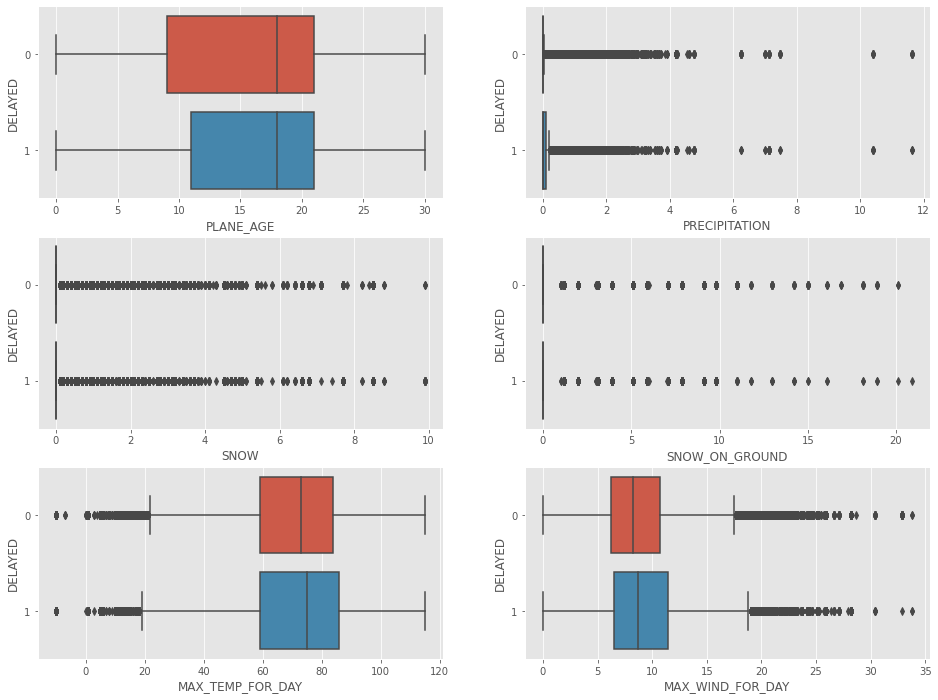

In [20]:
# Plot the remaining continuous variables with the delay status 
fig, ax = plt.subplots(3, 2, figsize=(16, 12))
sns.boxplot(data=data2, x="PLANE_AGE", y="DELAYED", orient='h', ax=ax[0,0])
sns.boxplot(data=data2, x="PRECIPITATION", y="DELAYED", orient='h', ax=ax[0,1])
sns.boxplot(data=data2, x="SNOW", y="DELAYED", orient='h', ax=ax[1,0])
sns.boxplot(data=data2, x="SNOW_ON_GROUND", y="DELAYED", orient='h', ax=ax[1,1])
sns.boxplot(data=data2, x="MAX_TEMP_FOR_DAY", y="DELAYED", orient='h', ax=ax[2,0])
sns.boxplot(data=data2, x="MAX_WIND_FOR_DAY", y="DELAYED", orient='h', ax=ax[2,1]);

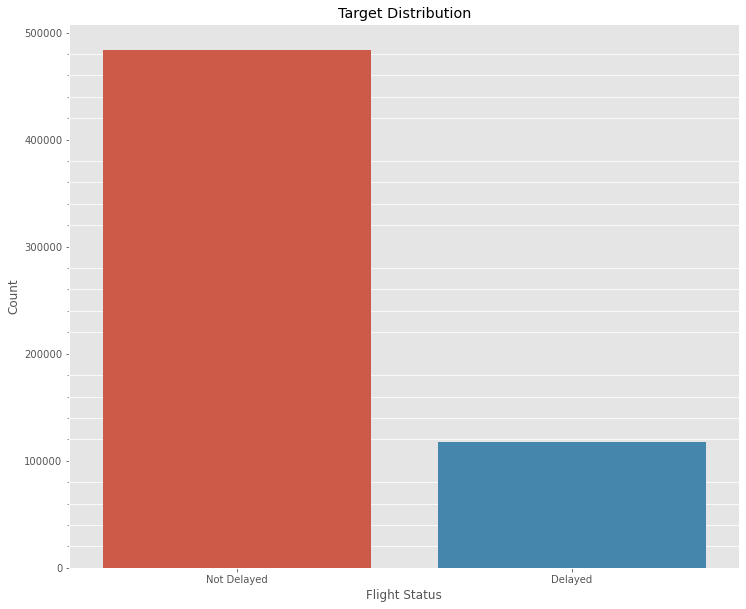

In [21]:
# Visualize the class (target) distribution
fig, ax = plt.subplots(figsize=(12,10))

# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax.yaxis.set_minor_locator(minor_locator)
ax.set_axisbelow(True)
plt.grid(which='both')

# Plot the target 
sns.countplot(data=data2, x='DELAYED', orient='v')
ax.set_title('Target Distribution')

# Change x-tick labels 
old_labels = [0, 1]
new_xlabels = ['Not Delayed', 'Delayed']
ax.set_xticks(old_labels)
ax.set_xticklabels(new_xlabels)

ax.set_xlabel("Flight Status")
ax.set_ylabel("Count");

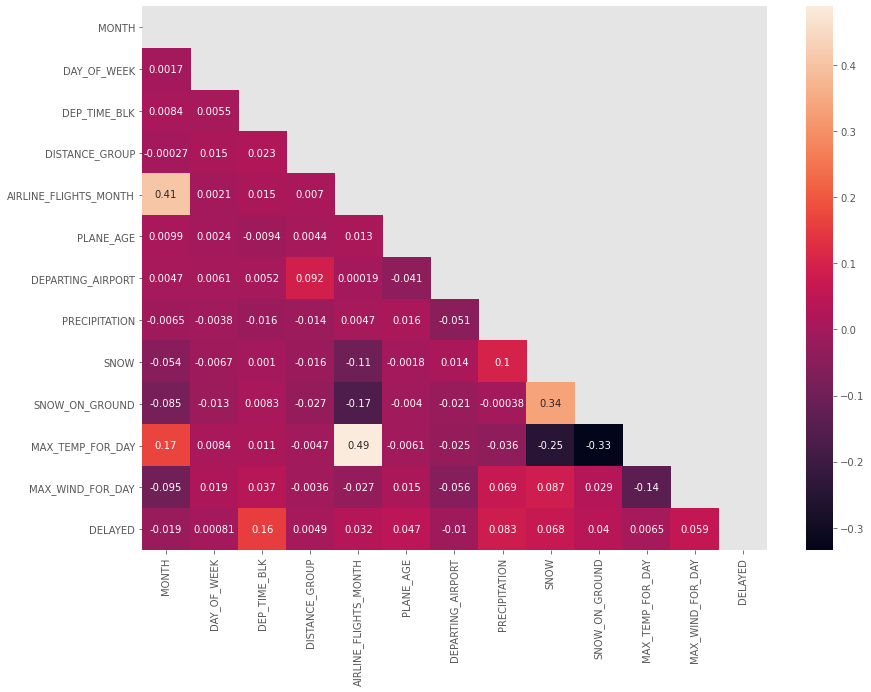

In [22]:
# Plot a heatmap with the Pearson coefficient values listed
fig, ax = plt.subplots(figsize=(14, 10))
mask = np.triu(np.ones_like(data2.corr(), dtype=bool))
sns.heatmap(data2.corr(), mask=mask, annot=True);

## Sampling

## Modeling

## Evaluation

## Conclusion

## Limitations/Further Work

# Sources
Link to original dataset: 
https://www.kaggle.com/datasets/threnjen/2019-airline-delays-and-cancellations/data?select=full_data_flightdelay.csv

Wall Street Journal annual airlines ranking report:
https://www.wsj.com/lifestyle/travel/best-airlines-us-2023-36e9ea20

